# Symmetric solution for strip of width 2b with constant precipitaiton surplus from t=0

IHE, transient groundwater

Olsthoorn, 2019-01-02

A solution, which shows the deline of the head in a strip due to bleeding to the fixed heads at both ends.

$$ s(x, t) = A \frac 4 \pi \sum _{j=1} ^\infty \left\{
\frac {(-1)^{j-1}} {2 j - 1}
\cos \left[(2 j -1) \frac \pi 2 \frac x b \right]
\exp \left[ -(2 j - 1)^2  \left( \frac \pi 2 \right)^2 \frac {kD} {b^2 S} t \right]
\right\} $$

A similar one exists for the situation in which the recharge is constant and equal to $p$ for $t>0$ (Bruggeman, 1999, p101 solution 133.16 (note that Bruggeman counts from $i=0$ which changs the power of $j-1$ to $j$ and $2j-1$ to $2j+1$). Also note that we now have $(2j-1)^3$ instead of $2j-1$ in the denominator of the factor in front of the $\cos(..)$:

$$ s(x, t) =  \frac {p} {2 kD} (b^2 - x^2) - \frac {16 p b^2} {\pi^3 kD} \sum _{j=1} ^\infty \left\{
\frac {(-1)^{j-1}} {(2 j - 1)^3}
\cos \left[(2 j -1) \frac \pi 2 \frac x b \right]
\exp \left[ -(2 j - 1)^2  \left( \frac \pi 2 \right)^2 \frac {kD} {b^2 S} t \right]
\right\} $$



This solution allows to simulate transient head and discharge in a strip of land subjected to constant or, through superpostion, varying recharge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

It seems profitable to define a function that computes the sum

In [2]:
def sInf(p, kD, b, x):
    '''Return steady state head change due to fixed recharge p starting at t=0'''
    return p / (2 * kD) * (b**2 - x**2)

def sDiff(p, x, b, S, kD, t):
    '''Return difference between steady state and actual state'''
    sign = -1
    if isinstance(x, np.ndarray):
        s = np.zeros_like(x)
    elif isinstance(t, np.ndarray):
        s = np.zeros_like(t)
    for j in range(1, 20):
        sign = -sign
        j2 = 2 * j - 1 
        s += sign / j2**3 * np.cos(j2 * np.pi / (2 * b) * x) * np.exp(-((j2 * np.pi) / (2 * b))**2 * kD / S * t) 
    return 16 * p * b**2 /(np.pi**3 * kD) * s
        

In [3]:
L = 150 # m (strip width)
b =L/2 # [m] half width of strip
x = np.linspace(-L/2, L/2, 201) # points, taking left at zero.
kD = 600 # m2/d
S = 0.1 # [-]
a = 1.0 # m, sudden head change at x = -L/2
times = np.linspace(0, 2, 11) # 
p = 0.01

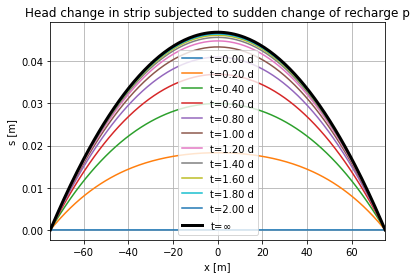

In [4]:
plt.title("Head change in strip subjected to sudden change of recharge p")
plt.xlabel('x [m]')
plt.ylabel('s [m]')
plt.xlim((-b, b))
plt.grid()

for t in times:
    s = sInf(p, kD, b, x) - sDiff(p, x, b, S, kD, t)
    plt.plot(x, s, label='t={:.2f} d'.format(t))

plt.plot(x, sInf(p, kD, b, x ), 'k', lw=3, label='t=$\infty$')
    
plt.legend()
plt.show()

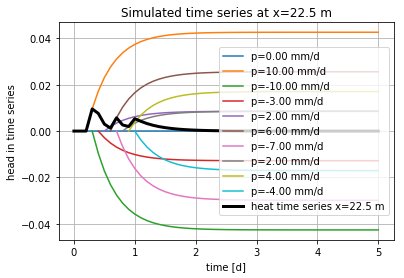

In [12]:
# simulate a time series with varying recharge.

# The recharge changes at switch times swt (may be irregularly spaced)
swt = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# The absolute recharge values starting at swt
Pabs= np.array([0, 10,    0,  -3,  -1,   5,  -2,   0,   4,   0]) * 1e-3

# The recharge changes, using Pabs[0] as the first change
P = np.hstack((Pabs[0], np.diff(Pabs)))

# Choose a point where the head time series is desired
x = 0.3 * b

# Choose times at which the head is to be computed (frequency is higher than that of the swt)
t = np.linspace(0, 5, 51)

# Initialize the time series with all zeros
stot = np.zeros_like(t)

plt.title("Simulated time series at x={:.1f} m".format(x))
plt.xlabel("time [d]")
plt.ylabel("head in time series")
plt.grid()


# Start uperposition
for p, st in zip(P, swt):
    I = t >= st # These are the times after the current switch time
    
    # heads for these times due to only this recharge change
    s = sInf(p, kD, b, x) - sDiff(p, x, b, S, kD, t[I] - st)
    
    # show it by way of illustration
    plt.plot(t[I], s, label='p={:.2f} mm/d'.format(1e3 *p))
    
    # superposition
    stot[I] += s
    
# Plot the final result
plt.plot(t, stot, 'k', lw=3, label='heat time series x={:.1f} m'.format(x))
plt.legend(loc='right')
plt.show()

## Discussion

Leave the plot inside the loop so omit the lines showing the net effect of each individual precipitation continuing from the particular switch times. The individual curves shows the effect of each recharge amount, including its final value and the rate at which it is reached. The decay of the head is also nicely shown at the end of the curve.

It's clear that the final stage of any rain duration can only be reached if this duration is long enough, with respect to the characteristic time of the solution, which is implied in the first exponent term of the summation of sDiff.

$$ e^{- \frac {\pi^2 kD} {4 b^2 S}  t} = e^{- \frac t T}$$

One can also characterize such as exponentially decaying system by its halftime. The relation between halftime $T_{50\%}$ and the characteristic time $T$ is obtained from

$$ e^{- \frac {t + T_{50\%}} T} = 0.5 e^{- \frac t T} $$

$$ - \frac {t + T_{50\%}} T = -\ln 2 - \frac t T $$

$$ \frac {T_{50\%}} T = \ln 2 \approx 0.67$$

with $T$ the characteristic time of this system
$$ T = \left( \frac 2 \pi \right) \frac {b^2 S} {kD} $$ 

In [15]:
T = (2/np.pi) * b**2 * S / kD
print('characteristic system time T = {:.2f} d'.format(T))
print('halftime of the system       = {:.2f} d'.format(np.log(2) * T))

characteristic system time T = 0.60 d
halftime of the system       = 0.41 d


This halftime can be observed from the graphs.

## Bibliography

Bruggeman, G.A. (1999) Analytical solutions of geohydrologial problems. Developments in water science Nr. 46, Elsevier, New York etc. ISBN 0-444-81829-4, 999pp